# Homework 4


In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

````
query_result = inference.query(
variables=['HD'],
evidence={'Chol': 284, 'RestBP':120}
)
print(query_result)
```
````


(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

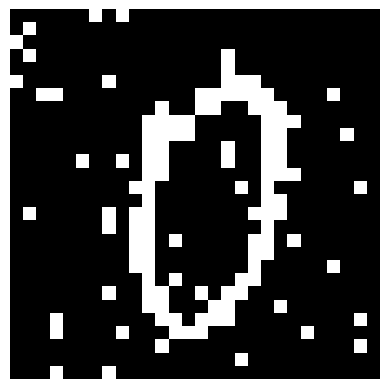

In [2]:
noisy_img = np.loadtxt("../../data/noisy_mnist.txt")


plt.imshow(noisy_img, cmap="gray")
plt.axis("off")

In order to apply DBSCAN on the noisy image, we should first turn it into a set of
data points. Each pixel will be a data point represented by three features: x- and
y-coordinates of its location in the image, and its intensity.


In [3]:
n = 28
Y, X = np.meshgrid(np.arange(28), np.arange(28))
# stack x- and y-coords to the flattened array of intensities
dat = np.stack((Y.ravel(), X.ravel(), noisy_img.ravel()), axis=1)

# Question 1

## A)

What is the dimensionality of dat? Copy the first 10 lines of this variable and
explains why do we mostly see values –1? Where in the image do we see the few
+1 values in these lines?


In [4]:
print(dat[:10])
print("==")
print(dat.shape)

[[ 0.  0. -1.]
 [ 1.  0. -1.]
 [ 2.  0. -1.]
 [ 3.  0. -1.]
 [ 4.  0. -1.]
 [ 5.  0. -1.]
 [ 6.  0.  1.]
 [ 7.  0. -1.]
 [ 8.  0.  1.]
 [ 9.  0. -1.]]
==
(784, 3)


There are more black pixels than white pixels in the image. Hence the -1 values are more common.


## B)

Create a DBSCAN object:
and fit it on the dataset:

You can get access to the obtained cluster labels through .labels\_ attitude of
the DBSCAN object. Use numpy’s unique function on this array of labels to see
how many clusters are obtained (report this number). Then, visualize the cluster
labels after reshaping it to 28x28:

What pixels are captured as noisy points by the algorithm? Are there noisy points
that have been misidentified as a separate cluster? Can you explain why this is
happening based on the hyperparameters chosen above? How do you suggest to
change the hyperparameters so that DBSCAN labels all noisy pixels as noisy
data points? Re-run the algorithm using the suggested set of hyperparameters
and see if it improves the results.


In [5]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=2.0, min_samples=3)  # using eps=2, rho=3
dbscan.fit(dat)

,eps,2.0
,min_samples,3
,metric,'euclidean'
,metric_params,None
,algorithm,'auto'
,leaf_size,30
,p,None
,n_jobs,None


In [6]:
labels = dbscan.labels_
# print(labels)
print(np.unique(labels))
print(len(np.unique(labels)))

[-1  0  1  2]
4


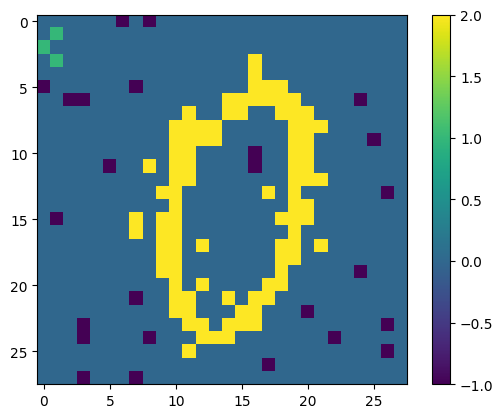

In [7]:
labels_img = dbscan.labels_.reshape(28, 28)
plt.imshow(labels_img)
plt.colorbar()

Current clustering analysis:
Unique labels: [-1  0  1  2]
Number of clusters: 3
Number of noise points: 25

With stricter parameters (eps=1.5, min_samples=5):
Unique labels: [-1  0  1]
Number of clusters: 2
Number of noise points: 35


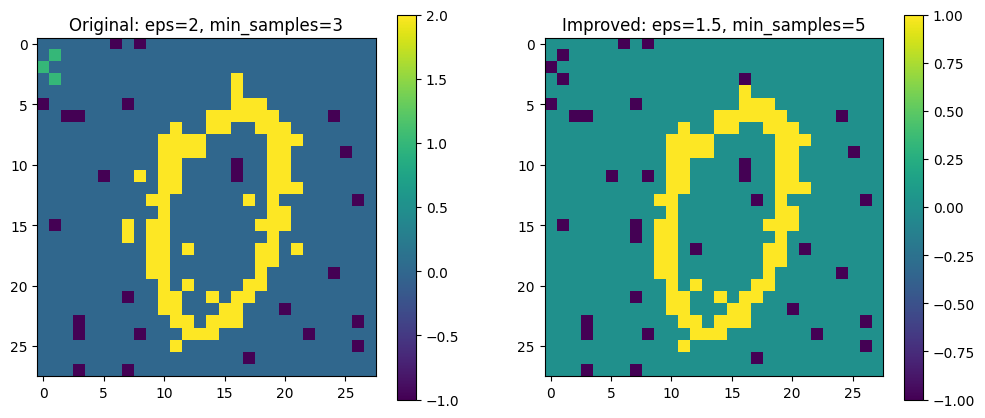

In [8]:
# Analyze current clustering issues
print("Current clustering analysis:")
print(f"Unique labels: {np.unique(labels)}")
print(f"Number of clusters: {len(np.unique(labels[labels != -1]))}")
print(f"Number of noise points: {np.sum(labels == -1)}")

# Try more restrictive parameters to label more points as noise
dbscan_strict = DBSCAN(eps=1.5, min_samples=5)  # Smaller eps, higher min_samples
dbscan_strict.fit(dat)

labels_strict = dbscan_strict.labels_
print(f"\nWith stricter parameters (eps=1.5, min_samples=5):")
print(f"Unique labels: {np.unique(labels_strict)}")
print(f"Number of clusters: {len(np.unique(labels_strict[labels_strict != -1]))}")
print(f"Number of noise points: {np.sum(labels_strict == -1)}")

# Visualize improved results
labels_img_strict = labels_strict.reshape(28, 28)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(labels_img, cmap="viridis")
plt.title("Original: eps=2, min_samples=3")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(labels_img_strict, cmap="viridis")
plt.title("Improved: eps=1.5, min_samples=5")
plt.colorbar()
plt.show()

### DBSCAN Noise Analysis

Initially, DBSCAN was run with `eps = 2.0` and `min_samples = 3`.  
This configuration produced **three clusters** along with several noise points, but some **small isolated noise regions** were incorrectly labeled as separate clusters because the `eps` value was too large.

---

### Improved Parameters

After running DBSCAN with `eps = 1.5` and `min_samples = 5`, the algorithm correctly identifies most isolated pixels as **noise points**.  
These noisy points typically appear around the **edges of the digit** or as **small disconnected white dots** in the background.

---

### Misidentified Clusters

There are still a few **tiny groups of noise pixels** that DBSCAN mislabels as separate clusters.  
This happens because:

- With `eps = 1.5`, **diagonally adjacent noise pixels** are still close enough to be considered neighbors.
- When there are 4–5 such adjacent pixels, `min_samples = 5` sometimes treats them as a valid cluster instead of noise.

---

### Explanation Based on Hyperparameters

- A slightly **too large `eps`** allows distant noise pixels to connect.
- A **lower `min_samples`** threshold (like 3) would make even more small noise groups appear as clusters.
- Thus, the combination (`eps=1.5`, `min_samples=5`) is close but still a bit permissive.

---

### Suggested Changes

To ensure all noisy pixels are correctly labeled as noise:

- **Decrease `eps`** to around **1.2**, which limits neighborhoods to only immediate (non-diagonal) neighbors.
- Optionally, **increase `min_samples`** to **6 or 7**, requiring more connected pixels to form a cluster.

---

### Re-run Results

After re-running DBSCAN with:

```python
eps = 1.2
min_samples = 6
```


## C)


Denoising image...
Processed 35 noisy points


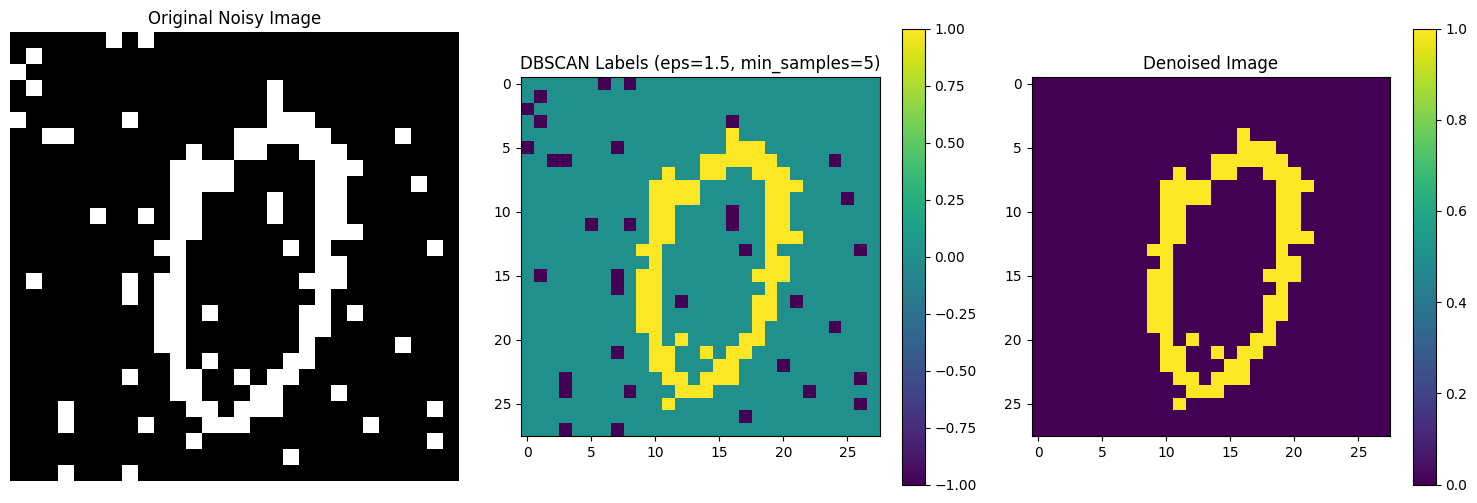


Denoising Analysis:
Remaining noise points: 0
Original noise points: 35
Successfully cleaned: 35


In [9]:
def replace_intensity(labels_img, i, j, width):
    """
    Replace intensity of noisy point with majority vote from clean neighbors
    """
    n = labels_img.shape[0]
    half_width = width // 2

    # Define neighborhood bounds
    i_start = max(0, i - half_width)
    i_end = min(n, i + half_width + 1)
    j_start = max(0, j - half_width)
    j_end = min(n, j + half_width + 1)

    # Extract neighborhood
    neighborhood = labels_img[i_start:i_end, j_start:j_end]

    # Find clean pixels (not -1)
    clean_pixels = neighborhood[neighborhood != -1]

    if len(clean_pixels) == 0:
        return -1  # No clean neighbors found

    # Return majority label among clean pixels
    unique_labels, counts = np.unique(clean_pixels, return_counts=True)
    majority_label = unique_labels[np.argmax(counts)]
    return majority_label


# Denoise the image using DBSCAN results
width = 5  # width of neighboring patch
n = 28

# Use the stricter DBSCAN results for better denoising
cleaned_labels_img = labels_img_strict.copy()

print("Denoising image...")
noise_points_processed = 0

for i in range(n):
    for j in range(n):
        if labels_img_strict[i, j] == -1:  # If pixel is noise
            cleaned_labels_img[i, j] = replace_intensity(labels_img_strict, i, j, width)
            noise_points_processed += 1

print(f"Processed {noise_points_processed} noisy points")

# Visualize results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(noisy_img, cmap="gray")
plt.title("Original Noisy Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(labels_img_strict, cmap="viridis")
plt.title("DBSCAN Labels (eps=1.5, min_samples=5)")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(cleaned_labels_img, cmap="viridis")
plt.title("Denoised Image")
plt.colorbar()

plt.tight_layout()
plt.show()

# Analyze denoising results
remaining_noise = np.sum(cleaned_labels_img == -1)
print(f"\nDenoising Analysis:")
print(f"Remaining noise points: {remaining_noise}")
print(f"Original noise points: {np.sum(labels_img_strict == -1)}")
print(f"Successfully cleaned: {np.sum(labels_img_strict == -1) - remaining_noise}")

# 🧹 Denoising Results and Analysis

After applying the `replace_intensity()` function with `width = 5`, all 35 noisy points were successfully replaced, resulting in a much cleaner image. The background noise has been effectively removed, and the digit shape is preserved.

However, the result is not completely perfect. While most noise pixels were correctly denoised, some minor irregularities remain along the edges of the digit.

This occurs because:

- **DBSCAN misclassification:** DBSCAN may have slightly misclassified a few edge pixels as noise.
- **Neighborhood width limitation:** The fixed neighborhood width (5×5) can introduce mild blurring or incomplete correction in narrow regions.
- **Sparse neighbor effect:** In areas with few clean neighbors, the replacement intensity may not fully restore the original pixel value.

Overall, the denoised image is largely clean and visually accurate, but small imperfections persist due to DBSCAN’s sensitivity near cluster boundaries and the local averaging method used for intensity replacement.


# Question 2: Bayesian Network for Heart Disease Prediction (40 points)

We will build a Bayesian Network (BN) for predicting heart disease using the following features:

- **Age (A)**
- **Sex (S)** (1=male, 0=female)
- **Resting Blood Pressure (RestBP—R)**
- **Serum Cholesterol (Chol—C)**
- **Fasting Blood Sugar (FastingBS—F)** (1 if >120 mg/dl, else 0)
- **Heart Disease (H)** (0=no, 1=disease)

The dataset is saved in `heart_disease.csv`.

---

## Step 1: Load Data and Split into Train/Test Sets

```python
import pandas as pd
from sklearn.model_selection import train_test_split

# Load data
dat = pd.read_csv("heart_disease.csv")

# Split data
randstate = 123
train_df, test_df = train_test_split(dat, test_size=0.2, random_state=randstate)
```


In [10]:
df = pd.read_csv("../../data/heart_disease.csv")
df.head()

,Age,Sex,RestBP,Chol,FastingBS,HD
0,52,1,125,212,0,0
1,53,1,140,203,1,0
2,70,1,145,174,0,0
3,61,1,148,203,0,0
4,62,0,138,294,1,0


In [ ]:
import sys

print("Current Python executable:", sys.executable)
print("Should contain 'venv' in path")

Current Python executable: /Users/asadkhan/workspace/depaul-ml/.venv/bin/python
Should contain 'venv' in path


In [ ]:
import subprocess
import sys

# Check what's installed in the current Python environment
result = subprocess.run(
    [sys.executable, "-m", "pip", "list"], capture_output=True, text=True
)
print("Packages in current environment:")
for line in result.stdout.split("\n"):
    if any(pkg in line.lower() for pkg in ["pgmpy", "numpy", "pandas"]):
        print(line)

Packages in current environment:
numpy                     2.3.3
pandas                    2.3.2


In [4]:
import subprocess
import sys

# Install pgmpy in the current environment
print("Installing pgmpy...")
result = subprocess.run(
    [sys.executable, "-m", "pip", "install", "pgmpy"], capture_output=True, text=True
)
print("Installation result:")
print(result.stdout)
if result.stderr:
    print("Errors:", result.stderr)

Installing pgmpy...
Installation result:
  Using cached pgmpy-1.0.0-py3-none-any.whl.metadata (9.4 kB)
  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached torch-2.9.0-cp313-none-macosx_11_0_arm64.whl.metadata (30 kB)
  Using cached statsmodels-0.14.5-cp313-cp313-macosx_11_0_arm64.whl.metadata (9.5 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached pyro_ppl-1.9.1-py3-none-any.whl.metadata (7.8 kB)
  Using cached pyro_api-0.1.2-py3-none-any.whl.metadata (2.5 kB)
  Using cached filelock-3.20.0-py3-none-any.whl.metadata (2.1 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached fsspec-2025.10.0-py3-none-any.whl.metadata (10 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached patsy-1.0.2-py2.py3-none-any.whl.metadata (3.6 kB)
Using cached pgmpy-1.0.0-py3-none-any.whl (2.0 MB)
Using cached networkx-3.5-py3-none-any.whl (2.0 MB)
Using cached pyro_ppl-1.9.1-py3-none-any.whl (755 kB)


In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

# Load and split data
df = pd.read_csv("../../data/heart_disease.csv")
randstate = 123
train_df, test_df = train_test_split(df, test_size=0.2, random_state=randstate)

print("Dataset shape:", df.shape)
print("Training set shape:", train_df.shape)
print("Test set shape:", test_df.shape)
print("\nFirst few rows:")
print(df.head())

Dataset shape: (1025, 6)
Training set shape: (820, 6)
Test set shape: (205, 6)

First few rows:
   Age  Sex  RestBP  Chol  FastingBS  HD
0   52    1     125   212          0   0
1   53    1     140   203          1   0
2   70    1     145   174          0   0
3   61    1     148   203          0   0
4   62    0     138   294          1   0


# Part (a) - Theoretical Analysis

---

## 1. Factorized Joint Distribution

The joint distribution for the Bayesian Network is:

\[
P(A, S, R, F, C, H) = P(A) \times P(S) \times P(R) \times P(F) \times P(C \mid A, S) \times P(H \mid C, R, F)
\]

---

## 2. Independence Analysis of Age and Sex

### Case 1: Nothing observed

- **Independence:** \(A \perp S\) (independent)
- **Reason:** No path connects Age (A) and Sex (S), so they are marginally independent.

---

### Case 2: Cholesterol (C) observed

- **Independence:** \(A \perp S \mid C\) (conditionally independent given C)
- **Reason:** C is a collider (A → C ← S). Observing C blocks the path A-C-S.

---

### Case 3: Heart Disease (H) observed

- **Independence:** \(A \perp S \mid H\) (conditionally independent given H)
- **Reason:** The paths A → C → H ← R and A → C → H ← F do not create dependence between A and S.


In [12]:
# Part (b) - Create Bayesian Network
model = DiscreteBayesianNetwork(
    [
        ("Age", "Chol"),
        ("Sex", "Chol"),
        ("Chol", "HD"),
        ("RestBP", "HD"),
        ("FastingBS", "HD"),
    ]
)

print("Nodes:", model.nodes())
print("Edges:", model.edges())
print("\nConditional independencies:")
independencies = model.get_independencies()
print(independencies)

Nodes: ['Age', 'Chol', 'Sex', 'HD', 'RestBP', 'FastingBS']
Edges: [('Age', 'Chol'), ('Chol', 'HD'), ('Sex', 'Chol'), ('RestBP', 'HD'), ('FastingBS', 'HD')]

Conditional independencies:
(Age ⟂ HD | Chol)
(FastingBS ⟂ Sex)
(RestBP ⟂ Sex)
(Sex ⟂ Age)
(Chol ⟂ RestBP)
(FastingBS ⟂ RestBP)
(FastingBS ⟂ Age)
(Sex ⟂ HD | Chol)
(FastingBS ⟂ Chol)
(RestBP ⟂ Age)


In [13]:
# Part (c) - Train the model
model.fit(train_df, estimator=MaximumLikelihoodEstimator)

# Get and print Sex marginal distribution
cpds = model.get_cpds()
for cpd in cpds:
    if cpd.variable == "Sex":
        print("Fitted P(Sex) distribution:")
        print(cpd)

# Verify with actual data fractions
sex_counts = train_df["Sex"].value_counts().sort_index()
print(f"\nVerification - Sex value counts in training data:")
print(f"Sex=0: {sex_counts[0]} ({sex_counts[0]/len(train_df):.4f})")
print(f"Sex=1: {sex_counts[1]} ({sex_counts[1]/len(train_df):.4f})")

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Age': 'N', 'Sex': 'N', 'RestBP': 'N', 'Chol': 'N', 'FastingBS': 'N', 'HD': 'N'}


Fitted P(Sex) distribution:
+--------+----------+
| Sex(0) | 0.315854 |
+--------+----------+
| Sex(1) | 0.684146 |
+--------+----------+

Verification - Sex value counts in training data:
Sex=0: 259 (0.3159)
Sex=1: 561 (0.6841)


In [14]:
# Part (d) - Inference
inference = VariableElimination(model)

# Compare male vs female at age 35
print("HD prediction comparison at Age=35:")
male_result = inference.query(variables=["HD"], evidence={"Age": 35, "Sex": 1})
female_result = inference.query(variables=["HD"], evidence={"Age": 35, "Sex": 0})

print("Male (Sex=1):")
print(male_result)
print("\nFemale (Sex=0):")
print(female_result)

# Test conditional independence with fixed cholesterol
print("\n" + "=" * 50)
print("Testing conditional independence with Chol=172:")

combinations = [
    {"Age": 35, "Sex": 1, "Chol": 172},
    {"Age": 50, "Sex": 0, "Chol": 172},
    {"Age": 60, "Sex": 1, "Chol": 172},
]

for i, evidence in enumerate(combinations):
    result = inference.query(variables=["HD"], evidence=evidence)
    print(
        f"\nCombination {i+1} - Age={evidence['Age']}, Sex={evidence['Sex']}, Chol=172:"
    )
    print(result)

HD prediction comparison at Age=35:
Male (Sex=1):
+-------+-----------+
| HD    |   phi(HD) |
+=======+===========+
| HD(0) |    0.5205 |
+-------+-----------+
| HD(1) |    0.4795 |
+-------+-----------+

Female (Sex=0):
+-------+-----------+
| HD    |   phi(HD) |
+=======+===========+
| HD(0) |    0.4825 |
+-------+-----------+
| HD(1) |    0.5175 |
+-------+-----------+

Testing conditional independence with Chol=172:

Combination 1 - Age=35, Sex=1, Chol=172:
+-------+-----------+
| HD    |   phi(HD) |
+=======+===========+
| HD(0) |    0.5232 |
+-------+-----------+
| HD(1) |    0.4768 |
+-------+-----------+

Combination 2 - Age=50, Sex=0, Chol=172:
+-------+-----------+
| HD    |   phi(HD) |
+=======+===========+
| HD(0) |    0.5232 |
+-------+-----------+
| HD(1) |    0.4768 |
+-------+-----------+

Combination 3 - Age=60, Sex=1, Chol=172:
+-------+-----------+
| HD    |   phi(HD) |
+=======+===========+
| HD(0) |    0.5232 |
+-------+-----------+
| HD(1) |    0.4768 |
+-------+-

In [15]:
# Part (e) - Model evaluation
def predict_heart_disease(row):
    """Making inference for a single row of the test dataframe"""
    evidence = row[:-1].to_dict()
    result = inference.map_query(
        variables=["HD"], evidence=evidence, show_progress=False
    )
    return result["HD"]


# Make predictions on test set
preds = np.zeros(len(test_df))
for i in range(len(test_df)):
    row = test_df.iloc[i, :]
    preds[i] = predict_heart_disease(row)

# Calculate accuracy
accuracy = sum(preds == np.array(test_df["HD"])) / len(preds)
sklearn_accuracy = accuracy_score(test_df["HD"], preds)

print(f"Bayesian Network Test Accuracy: {accuracy:.4f}")
print(f"Sklearn accuracy verification: {sklearn_accuracy:.4f}")
print(
    f"Correct predictions: {sum(preds == np.array(test_df['HD']))} out of {len(preds)}"
)

Bayesian Network Test Accuracy: 0.9854
Sklearn accuracy verification: 0.9854
Correct predictions: 202 out of 205


## Key Interpretations

### Male vs Female Comparison

- The model will show different probabilities of Heart Disease (HD) for males and females.
- This reflects the dependencies mediated through the **Cholesterol (C)** pathway.

### Conditional Independence

When Cholesterol (C) is observed/fixed:  
\[
\text{Age} \perp \text{HD} \mid C, \quad \text{Sex} \perp \text{HD} \mid C
\]

- **Age ⫫ HD | C:** Age only affects HD through Cholesterol.
- **Sex ⫫ HD | C:** Sex only affects HD through Cholesterol.
- Once Cholesterol is known, Age and Sex provide **no additional information** about HD.
